In [1]:
import numpy as np
import pandas as pd

from scipy.stats import iqr
from scipy.stats import uniform

from scipy.stats import binom
from scipy.stats import norm
from scipy.stats import poisson
from scipy.stats import expon

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Types of data
![types of data](screens/types_of_data.png)

# Skewed data
`mean` is always pulled in the direction of the skew
![skew](screens/skewed.png)

In [2]:
food_consumption = pd.read_csv('datasets/food_consumption.csv', index_col=0)
food_consumption

country food_category  consumption  co2_emission
1      Argentina          pork        10.51         37.20
2      Argentina       poultry        38.66         41.53
3      Argentina          beef        55.48       1712.00
4      Argentina     lamb_goat         1.56         54.63
5      Argentina          fish         4.36          6.96
...          ...           ...          ...           ...
1426  Bangladesh         dairy        21.91         31.21
1427  Bangladesh         wheat        17.47          3.33
1428  Bangladesh          rice       171.73        219.76
1429  Bangladesh      soybeans         0.61          0.27
1430  Bangladesh          nuts         0.72          1.27

[1430 rows x 4 columns]

In [3]:
food_consumption[food_consumption['country'] == 'USA'].agg([np.mean, np.median])

consumption  co2_emission
mean          44.65        156.26
median        14.58         15.34

In [4]:
food_consumption[(food_consumption['country'] == 'USA') | (food_consumption['country'] == 'Belgium')] \
    .groupby('country') \
    .agg([np.mean, np.median])

consumption        co2_emission       
               mean median         mean median
country                                       
Belgium   42.132727  12.59       100.19  21.34
USA       44.650000  14.58       156.26  15.34

In [5]:
food_consumption[(food_consumption['country'] == 'Belgium') | (food_consumption['country'] == 'USA')] \
    .pivot_table(index=['country'],
                 aggfunc=[np.mean, np.median],
                 values=['consumption', 'co2_emission'])

mean                   median            
        co2_emission consumption co2_emission consumption
country                                                  
Belgium       100.19   42.132727        21.34       12.59
USA           156.26   44.650000        15.34       14.58

In [6]:
food_consumption[(food_consumption['country'] == 'Belgium') | (food_consumption['country'] == 'USA')] \
    .pivot_table(index=['country'],
                 aggfunc=[np.mean, np.median],
                 values=['consumption', 'co2_emission'],
                 columns=['food_category'])

mean                                                 \
              co2_emission                                                  
food_category         beef   dairy   eggs   fish lamb_goat   nuts    pork   
country                                                                     
Belgium             482.31  336.43  11.57  30.29     46.23  12.96  136.80   
USA                1118.29  362.78  13.39  19.72     15.06  13.91   97.83   

                                       ...      median                \
                                       ... consumption                 
food_category poultry   rice soybeans  ...       dairy   eggs   fish   
country                                ...                             
Belgium         13.11  11.02     0.03  ...      236.19  12.59  18.97   
USA             53.72   8.80     0.02  ...      254.69  14.58  12.35   

                                                                     
                                                                     
food_category lamb_goat  nuts   pork poultry  rice soybeans   wheat  
country                                                              
Belgium            1.32  7.32  38.65   12.20  8.61     0.07  111.91  
USA                0.43  7.86  27.64   50.01  6.88     0.04   80.43  

[2 rows x 44 columns]

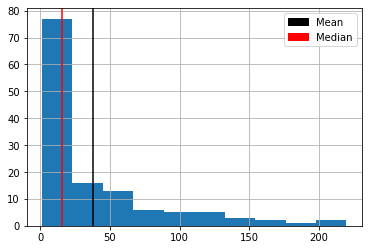

In [7]:
rice_consumption = food_consumption[food_consumption['food_category'] == 'rice']
rice_consumption['co2_emission'].hist() # .plot(kind='hist') works as well

plt.axvline(rice_consumption['co2_emission'].mean(), color='k')
black_patch = mpatches.Patch(color='k', label='Mean')

plt.axvline(rice_consumption['co2_emission'].median(), color='r')
red_patch = mpatches.Patch(color='r', label='Median')

plt.legend(handles=[black_patch, red_patch])
plt.show()

# Measures of spread

## Variance

In [8]:
# ddof - “Delta Degrees of Freedom", by default = 0. That's for whole pupulation, so DO NOT forget to set ddof=1
np.var(food_consumption[['consumption', 'co2_emission']], ddof=1)

consumption      2481.837554
co2_emission    23133.973639
dtype: float64

In [9]:
def my_variance(data: np.array, ddof=1, axis=0) -> np.array:
    squareDiff = (data - data.mean()) ** 2
    sumOfDiffs = np.sum(squareDiff)
    return sumOfDiffs / (data.shape[axis] - ddof)


my_variance(food_consumption[['consumption', 'co2_emission']]) \
    == np.var(food_consumption[['consumption', 'co2_emission']], ddof=1)

consumption     True
co2_emission    True
dtype: bool

## Standard deviation (SD, STD)

In [10]:
def my_std(data: np.array, ddof=1, axis=0) -> np.array:
    return np.sqrt(my_variance(data, ddof, axis))


my_std(food_consumption[['consumption', 'co2_emission']]) \
    == np.std(food_consumption[['consumption', 'co2_emission']], ddof=1)

consumption     True
co2_emission    True
dtype: bool

## Mean Absolute Deviation (MAD)

In [11]:
def my_mad(data: np.array, ddof=1, axis=0) -> np.array:
    absoluteDiff = np.abs(data - data.mean())
    sumOfAbsoluteDiff = np.sum(absoluteDiff)
    return sumOfAbsoluteDiff / (data.shape[axis] - ddof)


my_mad(food_consumption[['consumption', 'co2_emission']])

consumption     30.889104
co2_emission    89.744317
dtype: float64

## Interquartile Range (IQR)

![IQR](screens/IQR.png)

In [12]:
def my_iqr(data: np.array) -> np.array:
    return np.quantile(data, 0.75) - np.quantile(data, 0.25)


my_iqr(food_consumption[['consumption']]) \
    == iqr(food_consumption[['consumption']])

True

In [13]:
np.quantile(food_consumption['co2_emission'], np.linspace(0, 1, 5))

array([   0.    ,    5.21  ,   16.53  ,   62.5975, 1712.    ])

### Outlier

In [14]:
emissions_by_country = food_consumption.groupby('country')['co2_emission'].sum()

q1 = np.quantile(emissions_by_country, 0.25)
q3 = np.quantile(emissions_by_country, 0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outliers = emissions_by_country[(emissions_by_country < lower) | (emissions_by_country > upper)]
outliers

country
Argentina    2172.4
Name: co2_emission, dtype: float64

# Random Numbers and Probability

In [15]:
amir_deals = pd.read_csv('datasets/amir_deals.csv', index_col=0)
amir_deals

product   client status   amount  num_users
1    Product F  Current    Won  7389.52         19
2    Product C      New    Won  4493.01         43
3    Product B      New    Won  5738.09         87
4    Product I  Current    Won  2591.24         83
5    Product E  Current    Won  6622.97         17
..         ...      ...    ...      ...        ...
174  Product A  Current   Lost  5835.32         23
175  Product D  Current    Won  6377.50         12
176  Product D  Current    Won  3537.61         28
177  Product A  Current    Won  6448.07         34
178  Product D      New   Lost  7320.05         72

[178 rows x 5 columns]

In [16]:
product_counts = amir_deals['product'].value_counts()
product_counts

Product B    62
Product D    40
Product A    23
Product C    15
Product F    11
Product H     8
Product I     7
Product E     5
Product N     3
Product G     2
Product J     2
Name: product, dtype: int64

## Sample without replacement

In [17]:
np.random.seed(24)
sample_without_replacement = amir_deals.sample(5, replace=False)
sample_without_replacement

product   client status   amount  num_users
128  Product B  Current    Won  2070.25          7
149  Product D  Current    Won  3485.48         52
78   Product B  Current    Won  6252.30         27
105  Product D  Current    Won  4110.98         39
167  Product C      New   Lost  3779.86         11

## Sample with replacement

In [18]:
np.random.seed(24)
sample_with_replacement = amir_deals.sample(5, replace=True)
sample_with_replacement

product   client status   amount  num_users
163  Product D  Current    Won  6755.66         59
132  Product B  Current    Won  6872.29         25
88   Product C  Current    Won  3579.63          3
146  Product A  Current    Won  4682.94         63
146  Product A  Current    Won  4682.94         63

# Distributions

## Uniform distribution
Bus drives to the stop every 12th minute. What it the probability of waiting for the bus between 4 and 7 minutes?
![uniform_distribution](screens/uniform_distribution.png)

In [19]:
# Cumulative distribution function
wait_for_leq_7_minutes = uniform.cdf(7, 
                                 0, # lower limit
                                 12 # upper limit
                                ) 
wait_for_leq_4_minutes = uniform.cdf(4, 0, 12)

# The probability of waiting between 4 and 7 minutes
wait_for_leq_7_minutes - wait_for_leq_4_minutes

0.25000000000000006

In [20]:
# The probalility of waiting more then 7 minutes
wait_for_gt_7_minutes = 1 - wait_for_leq_7_minutes

# Survival function (also defined as 1 - cdf, but sf is sometimes more accurate).
wait_for_gt_7_minutes_sf = uniform.sf(7, 0, 12)
print('(1 - cdf):', wait_for_gt_7_minutes)
print('sf:', wait_for_gt_7_minutes_sf)

(1 - cdf): 0.41666666666666663
sf: 0.41666666666666663


#### Generate uniform distribution

In [21]:
# Random variates
random_uniform = uniform.rvs(0, # upper bound
                             5, # lower bound 
                             size=1000)

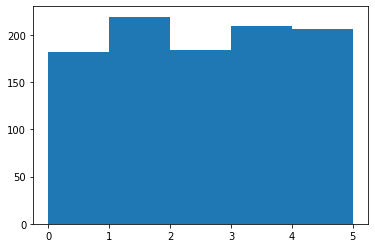

In [22]:
plt.hist(random_uniform, bins=range(0, 6))
plt.show()

## Binominal distribution
probability distribution of the number of successes of **independent** trials.
![binom.rvs](screens/binom.rvs.png)

Binominal distribution is discrete and can be describe with two parameters:
* n - total number of trials
* p - probability of success

In [23]:
# Random variates
binom.rvs(3, 0.5, size=10)

array([1, 3, 1, 3, 3, 1, 2, 1, 1, 1])

In [24]:
binom.rvs(3, 0.25, size=10)

array([2, 0, 0, 0, 0, 1, 1, 1, 1, 0])

In [25]:
# Probability mass function.
num_head = 7
num_trials = 10
prob_of_heads = 0.5
print('Probability of getting 7 heads out of 10 flips:', binom.pmf(num_head, num_trials, prob_of_heads))

Probability of getting 7 heads out of 10 flips: 0.11718750000000014


In [26]:
# Cumulative distribution function
binom.cdf(7, 10, 0,5)
print('Probability to get <= 7 head out of 10 flips: ', binom.cdf(num_head, num_trials, prob_of_heads))

Probability to get <= 7 head out of 10 flips:  0.9453125


In [27]:
# Survival function
print('Probability to get >= 7 head out of 10 flips: ', binom.sf(num_head, num_trials, prob_of_heads))

# OR
1 - binom.cdf(num_head, num_trials, prob_of_heads)

Probability to get >= 7 head out of 10 flips:  0.054687500000000014


0.0546875

## Normal Distribution
* mean - 161
* sigma - 7
![norm.cdf](screens/norm.cdf.png)
### Percent point function (inverse of cdf — percentiles)
![norm.ppf](screens/norm.ppf.png)

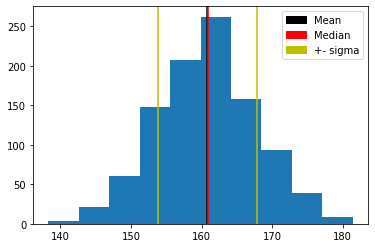

In [28]:
# Random variates
mean = 161
sigma = 7
random_norm = norm.rvs(mean, sigma, size=1000)

plt.hist(random_norm)

plt.axvline(random_norm.mean(), color='k')
black_patch = mpatches.Patch(color='k', label='Mean')

plt.axvline(np.median(random_norm), color='r')
red_patch = mpatches.Patch(color='r', label='Median')

plt.axvline(random_norm.mean() - 7, color='y')
plt.axvline(random_norm.mean() + 7, color='y')
yellow_patch = mpatches.Patch(color='y', label='+- sigma')

plt.legend(handles=[black_patch, red_patch, yellow_patch])
plt.show()

In [29]:
amir_deals = pd.read_csv('datasets/amir_deals.csv', index_col=0)
amir_deals

product   client status   amount  num_users
1    Product F  Current    Won  7389.52         19
2    Product C      New    Won  4493.01         43
3    Product B      New    Won  5738.09         87
4    Product I  Current    Won  2591.24         83
5    Product E  Current    Won  6622.97         17
..         ...      ...    ...      ...        ...
174  Product A  Current   Lost  5835.32         23
175  Product D  Current    Won  6377.50         12
176  Product D  Current    Won  3537.61         28
177  Product A  Current    Won  6448.07         34
178  Product D      New   Lost  7320.05         72

[178 rows x 5 columns]

In [30]:
amir_deals.describe()

amount   num_users
count   178.000000  178.000000
mean   4812.000337   37.651685
std    2058.173225   27.354794
min    -539.230000    1.000000
25%    3415.927500   14.250000
50%    4805.190000   32.500000
75%    6217.257500   58.000000
max    9913.270000   99.000000

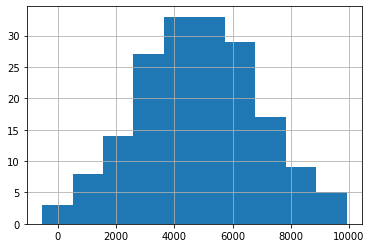

In [31]:
amir_deals['amount'].hist(bins=10)
plt.show()

In [32]:
# Cumulative distribution function
prob_less_7500 = norm.cdf(7500, amir_deals['amount'].mean(), amir_deals['amount'].std(ddof=1))
prob_less_7500

0.9042258221229889

In [33]:
prob_3000_to_7000 = norm.cdf(7000, amir_deals['amount'].mean(), amir_deals['amount'].std(ddof=1)) \
    - norm.cdf(3000, amir_deals['amount'].mean(), amir_deals['amount'].std(ddof=1))
prob_3000_to_7000

0.6668034681540913

In [34]:
# Percent point function (inverse of cdf — percentiles)
# Calculate amount that 25% of deals will be less than
pct_25 = norm.ppf(0.25, amir_deals['amount'].mean(), amir_deals['amount'].std(ddof=1))
pct_25

3423.783592448316

## Central Limit Theorem
The central limit theorem states that a sampling distribution of a sample statistic approaches the normal distribution as you take more samples, no matter the original distribution being sampled from.

*Only applies when samples taken randomly and they are independent*.

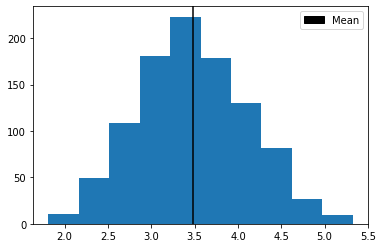

In [35]:
sample_means = []
for i in range(1000):
    sample = uniform.rvs(1, 5, size=5) # but why 1 -> 5 ?
    sample_means.append(sample.mean())

plt.hist(sample_means)

plt.axvline(np.mean(sample_means), color='k')
black_patch = mpatches.Patch(color='k', label='Mean')
plt.legend(handles=[black_patch])

plt.show()

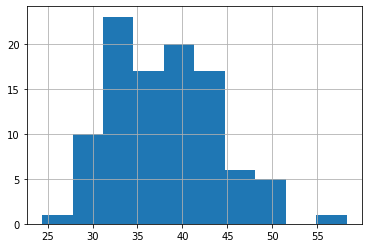

In [36]:
np.random.seed(104)

sample_means = []
for i in range(100):
    samp_20 = amir_deals['num_users'].sample(20, replace=True)
    samp_20_mean = np.mean(samp_20)
    sample_means.append(samp_20_mean)

sample_means_series = pd.Series(sample_means)
sample_means_series.hist()
plt.show()

## Poisson Distribution
* Events appear to happen at a certain rate, but completely at random. For instance, number of animals adopted from an animal shelter every week.
* Time unit does not matter as long as it is consistent.
* Looks like normal distribution when lambda is big.

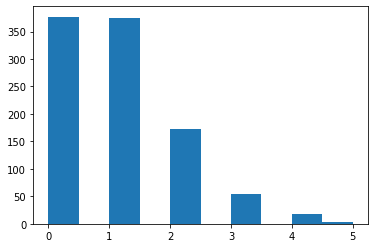

In [37]:
# Random variates
lambda_ = 1
poi = poisson.rvs(lambda_, size=1000)
plt.hist(poi)
plt.show()

In [40]:
# Probability mass-function
lambda_ = 5
mean = 4
prob_5 = poisson.pmf(lambda_, mean)
prob_5

0.1562934518505317

## Exponential distribution
Probability of time between Poisson events:
* Probability of > 1 day between adoptions
* Probability of < 10 minutes between restaurant arrivals

Time unit doesn't matter as long as it is consistent